<a href="https://colab.research.google.com/github/blinov-89/ulyanovsk/blob/main/LAMA_%D0%A3%D0%BB%D1%8C%D1%8F%D0%BD%D0%BE%D0%B2%D1%81%D0%BA_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# библио

In [ ]:
!pip install pyheif

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 23.3 MB/s 


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
import pandas as pd
import os
from PIL import Image
import numpy as np
import pyheif 
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# данные

In [ ]:
test_img_names = set(os.listdir('/content/drive/MyDrive/Ульяновск ИИ/test'))
train_img_names = set(os.listdir('/content/drive/MyDrive/Ульяновск ИИ/train'))

In [ ]:
test_img_names.intersection(train_img_names)

set()

In [ ]:
train_labels_df = pd.read_csv('/content/drive/MyDrive/Ульяновск ИИ/train.csv', sep=';', index_col=None)

In [ ]:
train_labels_names = set(train_labels_df['image_name'].values)

In [ ]:
train_labels_names.intersection(test_img_names)

set()

In [ ]:
len(train_labels_names.intersection(train_img_names)) == len(train_img_names)

True

In [ ]:
img_name = 'img_1596' + '.jpg'
train_labels_df[train_labels_df['image_name'] == img_name]

,image_name,distance
0,img_1596.jpg,4.88


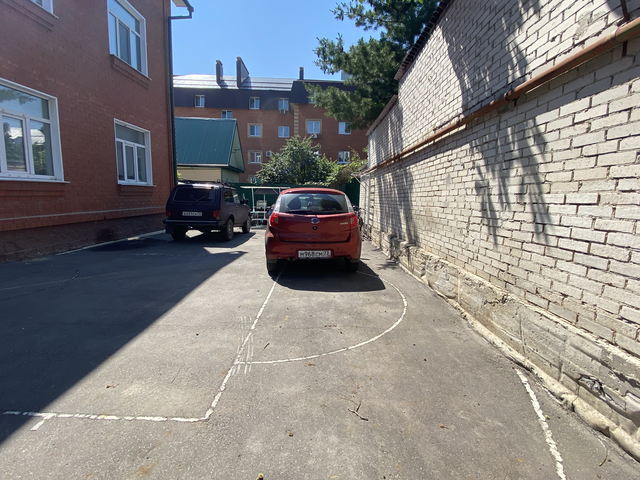

In [ ]:
img = Image.open(os.path.join('/content/drive/MyDrive/Ульяновск ИИ/train/', img_name))
img.thumbnail((640, 640), Image.ANTIALIAS)
img

# Train / test

In [ ]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
model.classes = [0, 2]  # person and car

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: ipython not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab

  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
train_data = []

for img_name in tqdm(train_img_names): 
  if 'heic' in img_name:
    heif_file = pyheif.read(os.path.join('/content/drive/MyDrive/Ульяновск ИИ/train/', img_name))
    img = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride)
  else:
    img = Image.open(os.path.join('/content/drive/MyDrive/Ульяновск ИИ/train/', img_name))
  results = model(np.array(img))
  if results.xyxy[0].shape != torch.Size([0, 6]):
    results = [img_name] + results.xyxy[0][0].numpy().tolist()
    train_data.append(results)

  0%|          | 0/530 [00:00<?, ?it/s]

In [ ]:
train_data_df = pd.DataFrame(train_data, columns = ['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'conf', 'class'])

In [ ]:
train_data_df = pd.merge(train_labels_df, train_data_df, how='left')

In [ ]:
test_data = []

for img_name in tqdm(test_img_names): 
  if 'heic' in img_name:
    heif_file = pyheif.read(os.path.join('/content/drive/MyDrive/Ульяновск ИИ/test/', img_name))
    img = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride)
  else:
    img = Image.open(os.path.join('/content/drive/MyDrive/Ульяновск ИИ/test/', img_name))
  results = model(np.array(img))
  if results.xyxy[0].shape != torch.Size([0, 6]):
    results = [img_name] + results.xyxy[0][0].numpy().tolist()
    test_data.append(results)

  0%|          | 0/521 [00:00<?, ?it/s]

In [ ]:
test_data_df = pd.DataFrame(test_data, columns = ['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'conf', 'class'])

# model lightautoml

In [ ]:
! pip install lightgbm

In [ ]:
import lightgbm

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
! pip install optuna

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
# from lightgbm import LGBMRegressor, log_evaluation, early_stopping
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install -U lightautoml

In [ ]:
%matplotlib inline

# Standard python libraries
import os
import time
import re

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

Step 0.2. Parameters

In [ ]:
N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 25 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.15 # Test size for metric check
TIMEOUT = 7200 # Time in seconds for automl run

In [ ]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [ ]:
tr_data, te_data = train_test_split(train_data_df, 
                                     test_size=TEST_SIZE,
                                     random_state=RANDOM_STATE)
print('Data splitted. Parts sizes: tr_data = {}, te_data = {}'.format(tr_data.shape, te_data.shape))

In [ ]:
%%time

task = Task('reg', loss = 'rmsle', metric = 'rmsle')

In [ ]:
%%time

roles = {
    'target': 'distance',
    'drop': ['image_name, class'],
}

In [ ]:
roles

{'target': 'distance', 'drop': ['image_name, class']}

In [ ]:
%%time 

cnt_trained = 0
results = []
rs_list = list(range(2000, 2005))
for it, rs in enumerate(rs_list):
    print('=' * 30)
    print('START RANDOM_STATE = {}'.format(rs))
    print('=' * 30)
    
    # Train AutoML
    automl = TabularAutoML(task = task, timeout = TIMEOUT, cpu_limit = N_THREADS, 
                           reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': rs},
                           general_params = {'use_algos': ['lgb', 'lgb_tuned', 'cb', 'cb_tuned']})
                           
    oof_pred = automl.fit_predict(tr_data, roles = roles)
    
    # Predict on test
    test_pred = automl.predict(te_data)
    cnt_trained += 1
    
    # Save predictions
    if it == 0:
        oof_pred_full = oof_pred.data[:, 0].copy()
        test_pred_full = test_pred.data[:, 0].copy()
    else:
        oof_pred_full += oof_pred.data[:, 0]
        test_pred_full += test_pred.data[:, 0]
    
    # Check scores for current predict and aggregated one
    rmsle_usual = mean_squared_log_error(te_data['distance'].values, test_pred.data[:, 0]) ** 0.5
    rmsle_full = mean_squared_log_error(te_data['distance'].values, test_pred_full / cnt_trained) ** 0.5
    results.append((rmsle_usual, rmsle_full, rmsle_full - rmsle_usual))
    
    print('Check scores...')
    print('Holdout score: {}'.format(rmsle_usual))
    print('Holdout score full: {}'.format(rmsle_full))
    print('Difference: {}'.format(rmsle_full - rmsle_usual))

Stdout logging level is ERROR.
Task: reg

Start automl preset with listed constraints:
- time: 7200.00 seconds
- CPU: 4 cores
- memory: 16 GB

Train data shape: (450, 8)



START RANDOM_STATE = 2000


Layer 1 train process start. Time left 7195.95 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.18325215857181798
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7161.83 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7161.82 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.18325215857181798
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.1797281824077789
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7121.66 secs

Layer 2 training complet

Check scores...
Holdout score: 0.16357939469117036
Holdout score full: 0.16357939469117036
Difference: 0.0
START RANDOM_STATE = 2001


Layer 1 train process start. Time left 7199.72 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.18561253074835132
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7190.50 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7190.48 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.18561253074835132
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.17776430512213845
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7114.58 secs

Layer 2 training comple

Check scores...
Holdout score: 0.1638555323697143
Holdout score full: 0.16366332143772527
Difference: -0.0001922109319890397
START RANDOM_STATE = 2002


Layer 1 train process start. Time left 7199.71 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.18374226657277315
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7190.05 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7190.05 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.18374226657277315
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.1835170211544137
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7147.38 secs

Layer 2 training complet

Check scores...
Holdout score: 0.160995982970148
Holdout score full: 0.16270775360957707
Difference: 0.0017117706394290666
START RANDOM_STATE = 2003


Layer 1 train process start. Time left 7199.71 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.18736432951295912
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7191.03 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7191.01 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.18736432951295912
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.19318237206218633
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7150.67 secs

Layer 2 training comple

Check scores...
Holdout score: 0.16458918470472744
Holdout score full: 0.16315193330528124
Difference: -0.0014372513994461988
START RANDOM_STATE = 2004


Layer 1 train process start. Time left 7199.70 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.18629467979443037
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7191.47 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7191.45 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.18629467979443037
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.18325303719865205
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7160.73 secs

Layer 2 training comple

Check scores...
Holdout score: 0.15966792355479625
Holdout score full: 0.16238430480298943
Difference: 0.002716381248193178
CPU times: user 14min 30s, sys: 1min 6s, total: 15min 37s
Wall time: 8min 54s


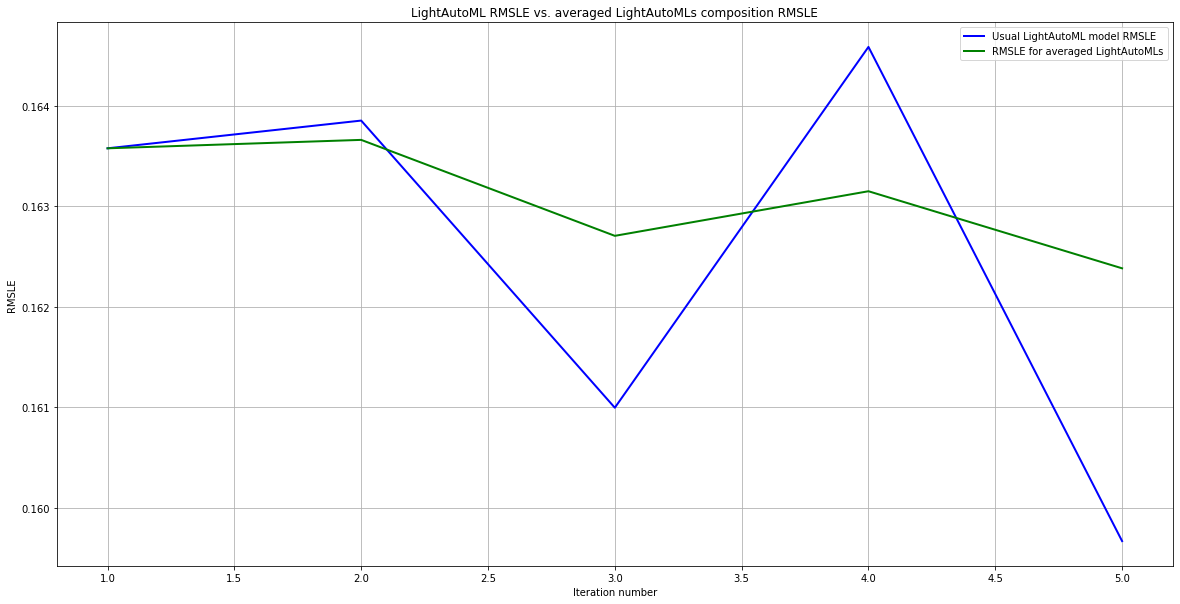

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(range(1, cnt_trained + 1), [res[0] for res in results], color = 'b', linewidth = 2, label = 'Usual LightAutoML model RMSLE')
plt.plot(range(1, cnt_trained + 1), [res[1] for res in results], color = 'g', linewidth = 2, label = 'RMSLE for averaged LightAutoMLs')
plt.grid()
plt.legend()
plt.title('LightAutoML RMSLE vs. averaged LightAutoMLs composition RMSLE')
plt.xlabel('Iteration number')
plt.ylabel('RMSLE')
plt.show()

In [ ]:
mean_rmsle = np.mean([res[0] for res in results])
mean_rmsle

0.16253760365811126

In [ ]:
differences = np.array([res[1] - mean_rmsle for res in results])

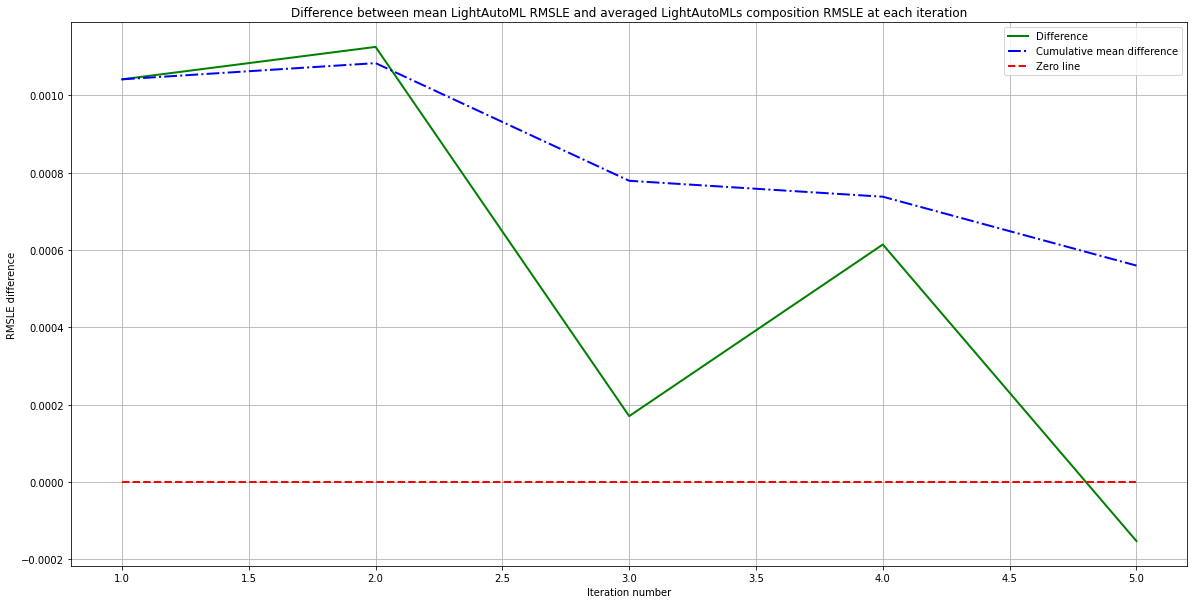

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(range(1, cnt_trained + 1), differences, color = 'g', linewidth = 2, label = 'Difference')
plt.plot(range(1, cnt_trained + 1), [np.mean(differences[0:i+1]) for i in range(len(differences))], 'b-.', linewidth = 2, label = 'Cumulative mean difference')
plt.plot(range(1, cnt_trained + 1), [0.0 for res in results], 'r--', linewidth = 2, label = 'Zero line')
plt.grid()
plt.legend()
plt.title('Difference between mean LightAutoML RMSLE and averaged LightAutoMLs composition RMSLE at each iteration')
plt.xlabel('Iteration number')
plt.ylabel('RMSLE difference')
plt.show()

In [ ]:
test_pred_full_0 = test_pred_full.copy() / cnt_trained

Step 5. Create AutoML with pseudo labelled data from holdout

In [ ]:
data_with_pseudolabels = te_data.copy()
data_with_pseudolabels['distance'] = test_pred_full_0.copy() 

new_dataset = pd.concat([tr_data, data_with_pseudolabels]).sample(frac = 1, random_state = 13).reset_index(drop = True)
print(tr_data.shape, new_dataset.shape)

(450, 8) (530, 8)


In [ ]:
tr_data['distance'].describe()

count    450.000000
mean       4.115956
std        1.745688
min        0.850000
25%        2.772500
50%        3.930000
75%        5.397500
max        9.380000
Name: distance, dtype: float64

In [ ]:
new_dataset['distance'].describe()

count    530.000000
mean       4.156897
std        1.720265
min        0.850000
25%        2.802500
50%        4.010000
75%        5.407500
max        9.380000
Name: distance, dtype: float64

In [ ]:
te_data

,image_name,distance,x_min,y_min,x_max,y_max,conf,class
140,img_1878.jpg,8.41,2936.570801,1280.322388,3504.945801,1593.722046,0.860224,2.0
398,img_2643.jpg,5.24,2945.979248,1201.688477,4032.000000,1737.720215,0.933723,2.0
6,img_1607.jpg,5.40,2975.591797,1375.612915,4020.673340,2377.658936,0.831510,2.0
334,img_2504.jpg,5.46,2276.096436,1332.959595,2913.904541,1751.285767,0.934128,2.0
322,img_2476.jpg,2.89,1468.491333,1213.918579,2287.119385,1892.974365,0.885403,2.0
...,...,...,...,...,...,...,...,...
33,img_1658.jpg,1.68,1132.829834,1054.314941,2956.040283,2576.765869,0.756032,2.0
78,img_2694.heic,7.78,1762.580811,1317.184570,2115.555420,1601.129272,0.846765,2.0
84,img_2705.heic,1.89,1357.019287,874.496582,2598.948730,1877.436035,0.905880,2.0
0,img_1596.jpg,4.88,1664.946045,1180.270630,2279.794434,1715.034180,0.765476,2.0


In [ ]:
test_data_df

,image_name,x_min,y_min,x_max,y_max,conf,class
0,img_2481.jpg,27.160145,1130.120850,1557.439819,1915.013428,0.939091,2.0
1,img_2756.jpg,1063.980103,783.201050,2885.009277,2032.664673,0.709168,2.0
2,img_1648.jpg,1539.686035,1026.110352,2346.775146,1728.591309,0.914746,2.0
3,img_2875.jpg,1701.129517,1161.646240,2076.007080,1473.176392,0.909792,2.0
4,img_2489.jpg,258.077545,1173.819458,1550.890259,1862.215942,0.931179,2.0
...,...,...,...,...,...,...,...
512,img_1859.jpg,1240.784058,1117.647583,2601.289795,2138.300537,0.894034,2.0
513,img_1942.jpg,1614.369995,1249.375000,2188.156250,1698.742798,0.923384,2.0
514,img_2702.heic,1639.310913,1281.522461,2321.456299,1854.151245,0.913751,2.0
515,img_2687.jpg,2587.642334,1324.156006,3595.201660,1721.382812,0.918617,2.0


In [ ]:
%%time 

cnt_trained = 0
results = []
rs_list = list(range(2000, 2005))
for it, rs in enumerate(rs_list):
    print('=' * 30)
    print('START RANDOM_STATE = {}'.format(rs))
    print('=' * 30)
    
    # Train AutoML
    automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': rs},
                       general_params = {'use_algos': ['lgb', 'lgb_tuned', 'cb', 'cb_tuned']})
    oof_pred = automl.fit_predict(new_dataset, roles = roles)
    
    # Predict on test
    test_pred = automl.predict(te_data)
    cnt_trained += 1
    
    # Save predictions
    if it == 0:
        oof_pred_full = oof_pred.data[:, 0].copy()
        test_pred_full = test_pred.data[:, 0].copy()
    else:
        oof_pred_full += oof_pred.data[:, 0]
        test_pred_full += test_pred.data[:, 0]
    
    # Check scores for current predict and aggregated one
    rmsle_usual = mean_squared_log_error(te_data['distance'].values, test_pred.data[:, 0]) ** 0.5
    rmsle_full = mean_squared_log_error(te_data['distance'].values, test_pred_full / cnt_trained) ** 0.5
    results.append((rmsle_usual, rmsle_full, rmsle_full - rmsle_usual))
    
    print('Check scores...')
    print('Holdout score: {}'.format(rmsle_usual))
    print('Holdout score full: {}'.format(rmsle_full))
    print('Difference: {}'.format(rmsle_full - rmsle_usual))

Stdout logging level is ERROR.
Task: reg

Start automl preset with listed constraints:
- time: 7200.00 seconds
- CPU: 4 cores
- memory: 16 GB

Train data shape: (530, 8)



START RANDOM_STATE = 2000


Layer 1 train process start. Time left 7199.72 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.1700277411901922
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7163.23 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7163.21 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.1700277411901922
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.16806487237249645
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7106.55 secs

Layer 2 training complete

Check scores...
Holdout score: 0.16192528734223707
Holdout score full: 0.16192528734223707
Difference: 0.0
START RANDOM_STATE = 2001


Layer 1 train process start. Time left 7199.72 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.1676691438563841
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7186.94 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7186.92 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.1676691438563841
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.16227106260003055
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7101.09 secs

Layer 2 training complete

Check scores...
Holdout score: 0.16034992030693374
Holdout score full: 0.16111715769463128
Difference: 0.0007672373876975447
START RANDOM_STATE = 2002


Layer 1 train process start. Time left 7199.70 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.1689387865422734
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7188.48 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7188.46 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.1689387865422734
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.16680458686578659
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7131.89 secs

Layer 2 training complete

Check scores...
Holdout score: 0.16095676979561407
Holdout score full: 0.16103310183795744
Difference: 7.633204234336333e-05
START RANDOM_STATE = 2003


Layer 1 train process start. Time left 7199.72 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.16836464550510885
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7188.41 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7188.40 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.16836464550510885
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.1689989982981895
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7134.68 secs

Layer 2 training complet

Check scores...
Holdout score: 0.16133537804679718
Holdout score full: 0.1611008221876634
Difference: -0.0002345558591337893
START RANDOM_STATE = 2004


Layer 1 train process start. Time left 7199.70 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.16990056320033445
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7188.05 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7188.04 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.16990056320033445
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.16800616914424046
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7101.50 secs

Layer 2 training comple

Check scores...
Holdout score: 0.16056677600278102
Holdout score full: 0.16096595801132044
Difference: 0.0003991820085394171
CPU times: user 18min 8s, sys: 1min 22s, total: 19min 30s
Wall time: 10min 48s


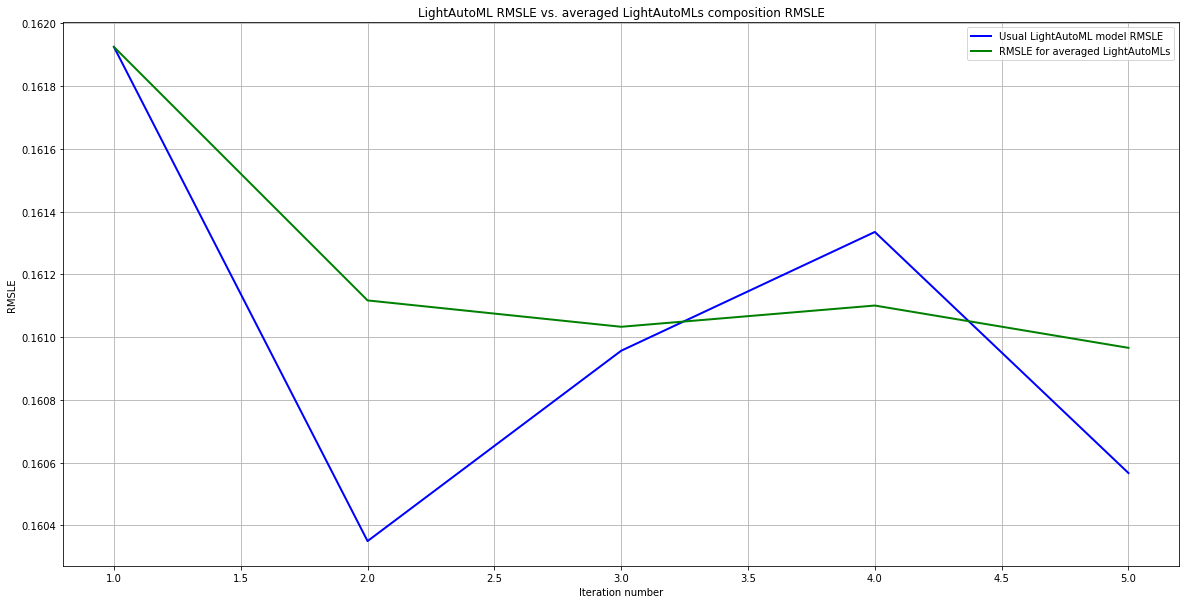

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(range(1, cnt_trained + 1), [res[0] for res in results], color = 'b', linewidth = 2, label = 'Usual LightAutoML model RMSLE')
plt.plot(range(1, cnt_trained + 1), [res[1] for res in results], color = 'g', linewidth = 2, label = 'RMSLE for averaged LightAutoMLs')
plt.grid()
plt.legend()
plt.title('LightAutoML RMSLE vs. averaged LightAutoMLs composition RMSLE')
plt.xlabel('Iteration number')
plt.ylabel('RMSLE')
plt.show()

In [ ]:
mean_rmsle = np.mean([res[0] for res in results])
mean_rmsle

0.1610268262988726

In [ ]:
differences = np.array([res[1] - mean_rmsle for res in results])

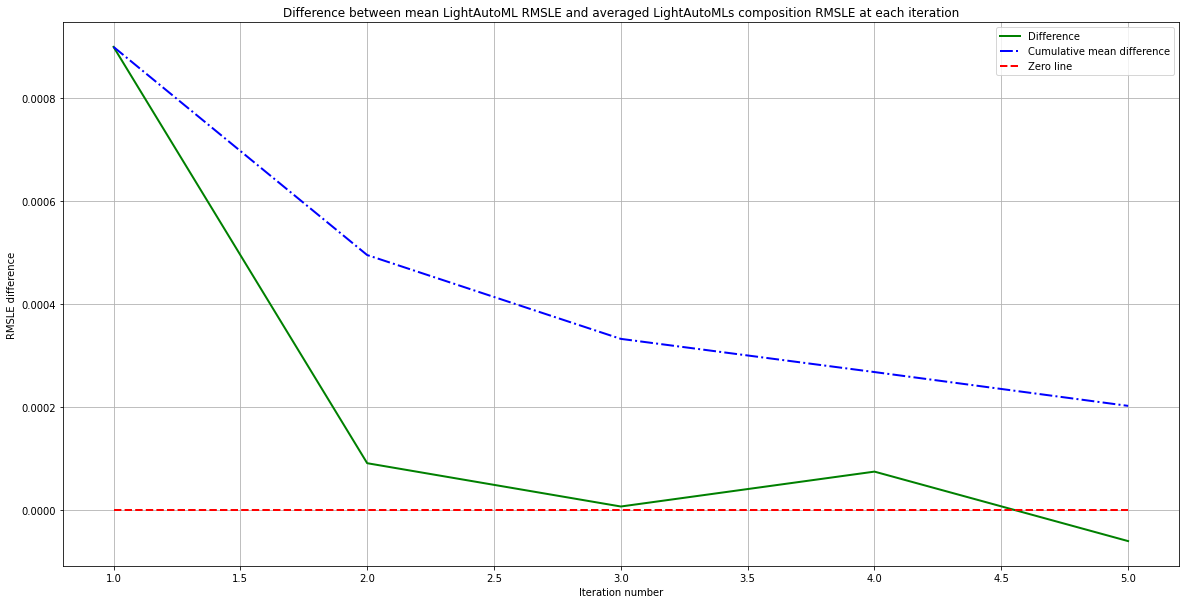

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(range(1, cnt_trained + 1), differences, color = 'g', linewidth = 2, label = 'Difference')
plt.plot(range(1, cnt_trained + 1), [np.mean(differences[0:i+1]) for i in range(len(differences))], 'b-.', linewidth = 2, label = 'Cumulative mean difference')
plt.plot(range(1, cnt_trained + 1), [0.0 for res in results], 'r--', linewidth = 2, label = 'Zero line')
plt.grid()
plt.legend()
plt.title('Difference between mean LightAutoML RMSLE and averaged LightAutoMLs composition RMSLE at each iteration')
plt.xlabel('Iteration number')
plt.ylabel('RMSLE difference')
plt.show()

Step 7. Train LightAutoML on full training dataset and pseudolabelled real test data

In [ ]:
test_data = test_data_df

In [ ]:
train_data = train_data_df

In [ ]:
%%time 

cnt_trained = 0
results = []
rs_list = list(range(2000, 2010))
for it, rs in enumerate(rs_list):
    print('=' * 30)
    print('START RANDOM_STATE = {}'.format(rs))
    print('=' * 30)
    
    # Train AutoML
    automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': rs},
                       general_params = {'use_algos': ['lgb', 'lgb_tuned', 'cb', 'cb_tuned']})
    oof_pred = automl.fit_predict(train_data, roles = roles)
    
    # Predict on test
    test_pred = automl.predict(test_data)
    cnt_trained += 1
    
    # Save predictions
    if it == 0:
        oof_pred_full = oof_pred.data[:, 0].copy()
        test_pred_full = test_pred.data[:, 0].copy()
    else:
        oof_pred_full += oof_pred.data[:, 0]
        test_pred_full += test_pred.data[:, 0]
    
    # Check scores for current predict and aggregated one
    rmsle_usual = mean_squared_log_error(train_data['distance'].values, oof_pred.data[:, 0]) ** 0.5
    rmsle_full = mean_squared_log_error(train_data['distance'].values, oof_pred_full / cnt_trained) ** 0.5
    results.append((rmsle_usual, rmsle_full, rmsle_full - rmsle_usual))
    
    print('Check scores...')
    print('OOF score: {}'.format(rmsle_usual))
    print('OOF score full: {}'.format(rmsle_full))
    print('Difference: {}'.format(rmsle_full - rmsle_usual))

Stdout logging level is ERROR.
Task: reg

Start automl preset with listed constraints:
- time: 7200.00 seconds
- CPU: 4 cores
- memory: 16 GB

Train data shape: (530, 8)



START RANDOM_STATE = 2000


Layer 1 train process start. Time left 7199.72 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.17987700443315094
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7188.47 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7188.46 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.17987700443315094
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.20137325405926948
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7154.04 secs

Layer 2 training comple

Check scores...
OOF score: 0.17421566051962478
OOF score full: 0.17421566051962478
Difference: 0.0
START RANDOM_STATE = 2001


Layer 1 train process start. Time left 7199.70 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.1801062037266037
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7188.41 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7188.39 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.1801062037266037
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.17905352762095306
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7130.62 secs

Layer 2 training complete

Check scores...
OOF score: 0.17677654960398229
OOF score full: 0.1731687405005047
Difference: -0.0036078091034775772
START RANDOM_STATE = 2002


Layer 1 train process start. Time left 7199.70 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.17655406324870987
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7187.65 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7187.64 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.17655406324870987
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.17305727521692296
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7061.43 secs

Layer 2 training comple

Check scores...
OOF score: 0.17414721891562202
OOF score full: 0.17149707815743656
Difference: -0.002650140758185454
START RANDOM_STATE = 2003


Layer 1 train process start. Time left 7199.73 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.17909865968641242
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7187.91 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7187.90 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.17909865968641242
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.176890158975683
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7139.19 secs

Layer 2 training complete

Check scores...
OOF score: 0.17580033941424544
OOF score full: 0.17170330971841744
Difference: -0.004097029695828008
START RANDOM_STATE = 2004


Layer 1 train process start. Time left 7199.62 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.1800036323099366
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7187.38 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7187.36 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.1800036323099366
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.17477754263520046
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7060.34 secs

Layer 2 training complete

Check scores...
OOF score: 0.17793866177093598
OOF score full: 0.17219564166078366
Difference: -0.005743020110152319
START RANDOM_STATE = 2005


Layer 1 train process start. Time left 7199.69 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.18183413783674035
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7188.54 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7188.52 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.18183413783674035
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.18102061950723597
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7100.98 secs

Layer 2 training comple

Check scores...
OOF score: 0.1763595049338896
OOF score full: 0.17227320075669042
Difference: -0.004086304177199185
START RANDOM_STATE = 2006


Layer 1 train process start. Time left 7199.71 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.18026820144297914
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7187.62 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7187.61 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.18026820144297914
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.18151546273146743
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7122.61 secs

Layer 2 training comple

Check scores...
OOF score: 0.17864369349050438
OOF score full: 0.17244155373732442
Difference: -0.006202139753179958
START RANDOM_STATE = 2007


Layer 1 train process start. Time left 7199.57 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.18130703619782162
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7188.16 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7188.15 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.18130703619782162
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.17790098054535408
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7056.25 secs

Layer 2 training comple

Check scores...
OOF score: 0.17792541767120099
OOF score full: 0.17263165292801882
Difference: -0.005293764743182161
START RANDOM_STATE = 2008


Layer 1 train process start. Time left 7199.70 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.178959611279003
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7188.34 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7188.32 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.178959611279003
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.17709813703489855
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7138.08 secs

Layer 2 training completed.

Check scores...
OOF score: 0.17588776040073514
OOF score full: 0.17258550967734884
Difference: -0.003302250723386302
START RANDOM_STATE = 2009


Layer 1 train process start. Time left 7199.70 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.18163551326768695
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7188.51 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7188.49 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.18163551326768695
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.17779658627925482
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7152.18 secs

Layer 2 training comple

Check scores...
OOF score: 0.18096202713880624
OOF score full: 0.17292169914745964
Difference: -0.008040327991346602
CPU times: user 40min 8s, sys: 2min 54s, total: 43min 3s
Wall time: 23min 7s


In [ ]:
test_pred_full_0 = test_pred_full.copy() / cnt_trained

In [ ]:
test_data_with_pseudolabels = test_data.copy()
test_data_with_pseudolabels['distance'] = test_pred_full_0

In [ ]:
full_dataset = pd.concat([train_data, test_data_with_pseudolabels]).sample(frac = 1, random_state = 13).reset_index(drop = True)
print(train_data.shape, full_dataset.shape)

(530, 8) (1047, 8)


In [ ]:
%%time 

cnt_trained = 0
results = []
rs_list = list(range(2000, 2007))
for it, rs in enumerate(rs_list):
    print('=' * 30)
    print('START RANDOM_STATE = {}'.format(rs))
    print('=' * 30)
    
    # Train AutoML
    automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       general_params = {'use_algos': ['lgb', 'lgb_tuned', 'cb', 'cb_tuned']},
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': rs})
    
    oof_pred = automl.fit_predict(full_dataset, roles = roles)
    
    # Predict on test
    test_pred = automl.predict(test_data)
    cnt_trained += 1
    
    # Save predictions
    if it == 0:
        oof_pred_full = oof_pred.data[:, 0].copy()
        test_pred_full = test_pred.data[:, 0].copy()
    else:
        oof_pred_full += oof_pred.data[:, 0]
        test_pred_full += test_pred.data[:, 0]

Stdout logging level is ERROR.
Task: reg

Start automl preset with listed constraints:
- time: 7200.00 seconds
- CPU: 4 cores
- memory: 16 GB

Train data shape: (1047, 8)



START RANDOM_STATE = 2000


Layer 1 train process start. Time left 7199.69 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.12508847360239347
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7176.28 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7176.27 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.12508847360239347
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.12316919967400047
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7045.33 secs

Layer 2 training comple

START RANDOM_STATE = 2001


Layer 1 train process start. Time left 7199.68 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.1254248724726962
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7176.32 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7176.31 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.1254248724726962
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.12319286291359688
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7081.39 secs

Layer 2 training complete

START RANDOM_STATE = 2002


Layer 1 train process start. Time left 7199.69 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.12428688583080988
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7175.91 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7175.90 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.12428688583080988
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.12240189558288302
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7010.88 secs

Layer 2 training comple

START RANDOM_STATE = 2003


Layer 1 train process start. Time left 7199.51 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.12437380801697685
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7175.21 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7175.20 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.12437380801697685
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.1223852073864168
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7077.57 secs

Layer 2 training complet

START RANDOM_STATE = 2004


Layer 1 train process start. Time left 7199.71 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.12531987993680838
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7176.04 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7176.03 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.12531987993680838
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.12249776001466961
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7081.81 secs

Layer 2 training comple

START RANDOM_STATE = 2005


Layer 1 train process start. Time left 7199.68 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.12449878980040392
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7175.28 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7175.26 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.12449878980040392
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.12913234499412807
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7012.49 secs

Layer 2 training comple

START RANDOM_STATE = 2006


Layer 1 train process start. Time left 7199.66 secs
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.1252775569620765
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Time left 7175.11 secs

Layer 1 training completed.

Layer 2 train process start. Time left 7175.10 secs
Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.1252775569620765
Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM completed
Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM ...
Fitting Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.1237472620531213
Lvl_1_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
Time left 7013.30 secs

Layer 2 training completed

CPU times: user 45min 8s, sys: 2min 36s, total: 47min 45s
Wall time: 25min 17s


# pred

In [ ]:
test_data_df['distance'] = test_pred_full / cnt_trained

In [ ]:
sample_solution_df = test_data_df[['image_name', 'distance']]

In [ ]:
!pip install --upgrade pandas

In [ ]:
lost_test_items = []

for file_name in test_img_names - set(sample_solution_df['image_name'].values):
  lost_test_items.append([file_name, 0])

In [ ]:
lost_test_items_df = pd.DataFrame(lost_test_items, columns=['image_name', 'distance'])

In [ ]:
sample_solution_df = pd.concat([sample_solution_df, lost_test_items_df])

In [ ]:
sample_solution_df.to_csv('sample_solution.csv', sep=';', index=False)

In [ ]:
# sample_solution_df.to_csv('LightAutoML_pseudolabelled_multistart.csv', index = False)